# ABU量化系统使用文档 

<center>
        <img src="./image/abu_logo.png" alt="" style="vertical-align:middle;padding:10px 20px;"><font size="6" color="black"><b>第22节 美股全市场回测</b></font>
</center>

-----------------

作者: 阿布

阿布量化版权所有 未经允许 禁止转载

[abu量化系统github地址](https://github.com/bbfamily/abu) (欢迎+star)

[本节ipython notebook](https://github.com/bbfamily/abu/tree/master/abupy_lecture)

在第19节‘数据源’中分别获取了各个市场的6年交易数据，本节将做美股市场全市场回测，以及ump主裁，边裁优化示例。

首先导入abupy中本节使用的模块：

In [1]:
# 基础库导入

from __future__ import print_function
from __future__ import division

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets
%matplotlib inline

import os
import sys
# 使用insert 0即只使用github，避免交叉使用了pip安装的abupy，导致的版本不一致问题
sys.path.insert(0, os.path.abspath('../'))
import abupy

# 使用沙盒数据，目的是和书中一样的数据环境
abupy.env.enable_example_env_ipython()

enable example env will only read RomDataBu/df_kl.h5


In [2]:
from abupy import AbuFactorAtrNStop, AbuFactorPreAtrNStop, AbuFactorCloseAtrNStop, AbuFactorBuyBreak, ABuSymbol
from abupy import abu, EMarketTargetType, AbuMetricsBase, ABuMarketDrawing, ABuProgress, ABuSymbolPd, ABuMarket, AbuSymbolUS
from abupy import EMarketTargetType, EDataCacheType, EMarketSourceType, EMarketDataFetchMode, EStoreAbu
# 关闭沙盒数据
abupy.env.disable_example_env_ipython()

disable example env


所有获取的数据已经存放在百度云盘上，后面的章节使用的数据都是本节更新的数据，建议直接从云盘下载入库完毕的数据库，不需要从各个数据源再一个一个的下载数据进行入库，百度云地址如下：

[csv格式美股，A股，港股，币类，期货6年日k数据](https://pan.baidu.com/s/1geNZgqf) 密码: gvtr

下面的数据存贮格式为hdf5数据，由于hdf5文件解压后非常大，还需要区分python版本，所以如果没有足够的存贮空间
特别是python2下，建议使用csv格式的缓存文件：

[mac系统python3 美股，A股，港股，币类，期货6年日k数据](https://pan.baidu.com/s/1o8sldNk) 密码: ecyp

[mac系统python2 美股6年日k数据: ](https://pan.baidu.com/s/1geHR9Lp) 密码: uaww

[windows python3 美股，A股，港股，币类，期货6年日k数据](https://pan.baidu.com/s/1bzeVHO) 密码: 3cwe

[windows python2 美股6年日k数据: ](https://pan.baidu.com/s/1i5MNzKx) 密码: 63r3



下载完毕上述数据后，hdf5解压得到df_kl.h5文件，csv解压得到csv文件夹，解压后放到下面路径下即可

In [ ]:
if abupy.env.g_is_mac_os:
    !open $abupy.env.g_project_data_dir
else:
    !echo $abupy.env.g_project_data_dir

如果不想通过直接下载数据文件的方式，也可运行下面的cell点击按钮后进行美股数据全市场更新，如果运行过就不要重复运行了：

In [3]:
def tx_us():
    abupy.env.g_market_source = EMarketSourceType.E_MARKET_SOURCE_tx
    abupy.env.g_data_cache_type = EDataCacheType.E_DATA_CACHE_CSV
    abu.run_kl_update(start='2011-08-08', end='2017-08-08', market=EMarketTargetType.E_MARKET_TARGET_US, n_jobs=32)

# 避免使用notebook运行run all时运行不想执行的代码
_ = ipywidgets.interact_manual(tx_us)

买入因子，卖出因子等依然使用相同的设置，如下所示：

In [3]:
# 初始化资金500万
read_cash = 5000000

# 买入因子依然延用向上突破因子
buy_factors = [{'xd': 60, 'class': AbuFactorBuyBreak},
               {'xd': 42, 'class': AbuFactorBuyBreak}]

# 卖出因子继续使用上一节使用的因子
sell_factors = [
    {'stop_loss_n': 1.0, 'stop_win_n': 3.0,
     'class': AbuFactorAtrNStop},
    {'class': AbuFactorPreAtrNStop, 'pre_atr_n': 1.5},
    {'class': AbuFactorCloseAtrNStop, 'close_atr_n': 1.5}
]
abupy.env.g_market_target = EMarketTargetType.E_MARKET_TARGET_US
abupy.env.g_data_fetch_mode = EMarketDataFetchMode.E_DATA_FETCH_FORCE_LOCAL

### 1. 美股交易训练集回测

下面将回测市场设置为美股市场：

In [3]:
abupy.env.g_market_target = EMarketTargetType.E_MARKET_TARGET_US

将数据读取模式设置为本地数据模式，即进行全市场回测时最合适的模式，运行效率高，且分类数据更新和交易回测。

In [4]:
abupy.env.g_data_fetch_mode = EMarketDataFetchMode.E_DATA_FETCH_FORCE_LOCAL

下面根据下载的数据缓存类型设置缓存类型，如果下载解压的是csv需要勾选use_csv，如果是hdf5不需要勾选：

In [11]:
def select_store_cache(use_csv):
    if use_csv:
        abupy.env.g_data_cache_type = EDataCacheType.E_DATA_CACHE_CSV
    else:
        abupy.env.g_data_cache_type = EDataCacheType.E_DATA_CACHE_HDF5
    print(abupy.env.g_data_cache_type)
        
use_csv = ipywidgets.Checkbox(True)
_ = ipywidgets.interact(select_store_cache, use_csv=use_csv)

EDataCacheType.E_DATA_CACHE_HDF5


下面通过env中的设置将回测中的symbols切分为回测训练集与回测测试集，且打开回测生成买入时刻特征开关：

详情请阅读ABuMarket模块

In [7]:
# 回测时生成买入时刻特征
abupy.env.g_enable_ml_feature = True
# 回测时将symbols切割分为训练集数据和测试集两份，使用训练集进行回测
abupy.env.g_enable_train_test_split = True

下面设置回测时切割训练集，测试集使用的切割比例参数，默认为10，即切割为10份，9份做为训练，1份做为测试

由于美股股票数量多，所以切割分为4份，3份做为训练集，1份做为测试集，如下所示：

In [8]:
abupy.env.g_split_tt_n_folds = 4

资金管理依然使用默认atr，每笔交易的买入基数资金设置为万分之15，这个值如果设置太大，比如初始默认的0.1的话，将会导致太多的股票由于资金不足无法买入，丧失全市场回测的意义，如果太小的话又会导致资金利用率下降，导致最终收益下降：

更多资金管理请阅读相关源代码或《量化交易之路》中相关内容

In [9]:
# 每笔交易的买入基数资金设置为万分之15
abupy.beta.atr.g_atr_pos_base = 0.0015

在上面run_kl_update中更新了从2011-08-08至2017-08-08，由于在买入时刻生成特征，所以要保留一年的数据做为特征数据回测时段，所以下面的回测start使用2012-08-08至2017-08-08，即向后推了一年做回测：

下面开始回测，第一次运行select：run loop back，然后点击run select，如果已经回测过可select：load train data直接从缓存数据读取：

In [ ]:
abu_result_tuple = None
def run_loop_back():
    global abu_result_tuple
    abu_result_tuple, _ = abu.run_loop_back(read_cash,
                                                   buy_factors,
                                                   sell_factors,
                                                   choice_symbols=None,
                                                   start='2012-08-08', end='2017-08-08')
    # 把运行的结果保存在本地，以便之后分析回测使用，保存回测结果数据代码如下所示
    abu.store_abu_result_tuple(abu_result_tuple, n_folds=5, store_type=EStoreAbu.E_STORE_CUSTOM_NAME, 
                               custom_name='train_us')
    ABuProgress.clear_output()

def run_load_train():
    global abu_result_tuple
    abu_result_tuple = abu.load_abu_result_tuple(n_folds=5, store_type=EStoreAbu.E_STORE_CUSTOM_NAME, 
                                                 custom_name='train_us')

def select(select):
    if select == 'run loop back':
        run_loop_back()
    else:
        run_load_train()

_ = ipywidgets.interact_manual(select, select=['run loop back', 'load train data'])

买入后卖出的交易数量:89418
买入后尚未卖出的交易数量:2012
胜率:46.5220%
平均获利期望:8.4475%
平均亏损期望:-5.6229%
盈亏比:1.3312
策略收益: 61.3978%
基准收益: 111.5646%
策略年化收益: 12.2991%
基准年化收益: 22.3484%
策略买入成交比例:31.7084%
策略资金利用率比例:88.6240%
策略共执行1258个交易日


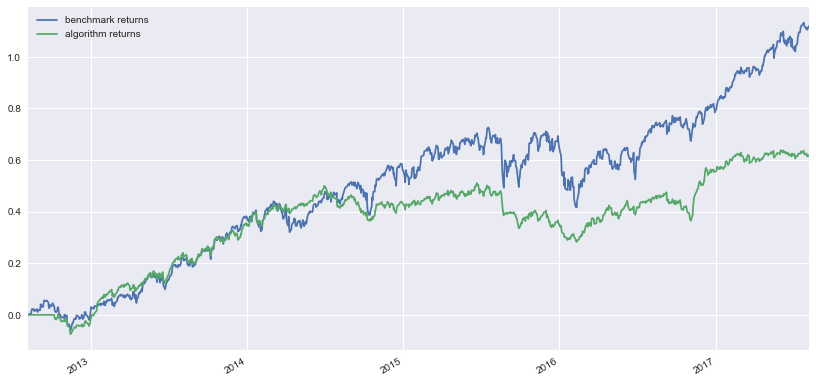

In [11]:
metrics_train = AbuMetricsBase.show_general(*abu_result_tuple, only_show_returns=True)

### 2. 美股交易测试集回测

下面通过env中设置使用刚才切分的测试集美股symbol，它使用pickle读取之前已经切割好的本地化测试集股票代码序列：

In [6]:
# 测试集回测时也不生成买入时刻特征了，为提高回测运行效率
abupy.env.g_enable_ml_feature = False
# 回测时使用切割好的测试数据
abupy.env.g_enable_last_split_test = True

提高g_atr_pos_base为0.007（因为默认切割训练集与测试集数据比例为4:1，所以提高g_atr_pos_base为之前的大概3-5倍都可以：

In [13]:
abupy.beta.atr.g_atr_pos_base = 0.007

下面开始回测，第一次运行select：run loop back，然后点击run select_test，如果已经回测过可select：load test data直接从缓存数据读取：

In [14]:
abu_result_tuple_test = None
def run_loop_back_test():
    global abu_result_tuple_test
    abu_result_tuple_test, _ = abu.run_loop_back(read_cash,
                                                 buy_factors,
                                                 sell_factors,
                                                 choice_symbols=None,
                                                 start='2012-08-08', end='2017-08-08')
    # 把运行的结果保存在本地，以便之后分析回测使用，保存回测结果数据代码如下所示
    abu.store_abu_result_tuple(abu_result_tuple_test, n_folds=5, store_type=EStoreAbu.E_STORE_CUSTOM_NAME, 
                               custom_name='test_us')
    ABuProgress.clear_output()

def run_load_test():
    global abu_result_tuple_test
    abu_result_tuple_test = abu.load_abu_result_tuple(n_folds=5, store_type=EStoreAbu.E_STORE_CUSTOM_NAME, 
                                                 custom_name='test_us')

def select_test(select):
    if select == 'run loop back':
        run_loop_back_test()
    else:
        run_load_test()

_ = ipywidgets.interact_manual(select_test, select=['run loop back', 'load test data'])

买入后卖出的交易数量:29786
买入后尚未卖出的交易数量:625
胜率:46.5420%
平均获利期望:8.4243%
平均亏损期望:-5.7298%
盈亏比:1.3117
策略收益: 63.2158%
基准收益: 111.5646%
策略年化收益: 12.6633%
基准年化收益: 22.3484%
策略买入成交比例:20.8674%
策略资金利用率比例:90.2922%
策略共执行1258个交易日


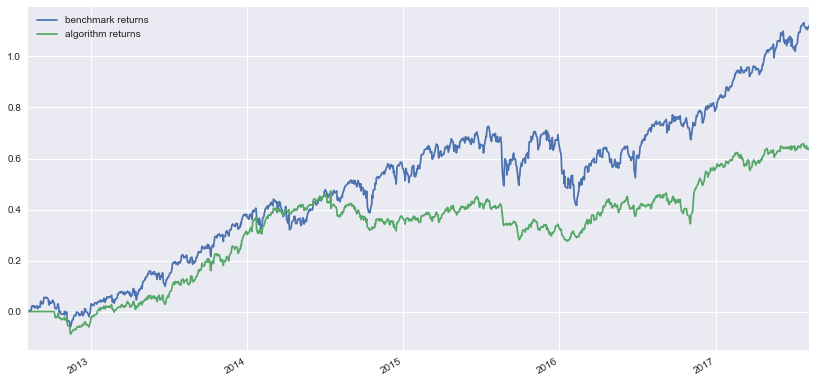

In [15]:
AbuMetricsBase.show_general(*abu_result_tuple_test, only_show_returns=True)

### 3. 满仓乘数

上述回测结果中可以看到策略买入成交比例都不高，《量化交易之路》中讲解了资金限制对度量的影响，以及满仓乘数的概念以及使用，《量化交易之路》中通过把初始资金扩大到非常大，但是每笔交易的买入基数却不增高，来使交易全部都成交，再使用满仓乘数的示例，由于需要再次进行全市场回测，比较耗时。

下面直接示例通过AbuMetricsBase中的transform_to_full_rate_factor接口将之前的回测结果转换为使用大初始资金回测的结果：

第一次运行select：transform，然后点击run select_full，如果已经运行过可select：load直接从缓存数据读取：

备注：即使不重新做全市场回测，由于设计所有交易单的重新计算，所有仍然需要时间，下面操作属于耗时操作

In [12]:
test_frm = None
def run_transform():
    global test_frm
    metrics_test = AbuMetricsBase(*abu_result_tuple_test)
    test_frm = metrics_test.transform_to_full_rate_factor(n_process_kl=4, show=False)
    
    # 转换后保存起来，下次直接读取，不用再转换了
    from abupy import AbuResultTuple
    test_us_fr = AbuResultTuple(test_frm.orders_pd, test_frm.action_pd, test_frm.capital, test_frm.benchmark)
    abu.store_abu_result_tuple(test_us_fr, n_folds=5, store_type=EStoreAbu.E_STORE_CUSTOM_NAME, 
                               custom_name='test_us_full_rate')

def run_load():
    global test_frm
    test_us_fr = abu.load_abu_result_tuple(n_folds=5, store_type=EStoreAbu.E_STORE_CUSTOM_NAME, 
                                           custom_name='test_us_full_rate')
    # 本地读取后使用AbuMetricsBase构造度量对象，参数enable_stocks_full_rate_factor=True, 即使用满仓乘数
    test_frm = AbuMetricsBase(test_us_fr.orders_pd, test_us_fr.action_pd, test_us_fr.capital, test_us_fr.benchmark,
                              enable_stocks_full_rate_factor=True)
    test_frm.fit_metrics()

def select_full(select):
    if select == 'transform':
        run_transform()
    else:
        run_load()

_ = ipywidgets.interact_manual(select_full, select=['transform', 'load'])

please wait! load_pickle....: /Users/Bailey/abu/data/cache/n5_test_us_full_rate_capital
please wait! load_pickle....: /Users/Bailey/abu/data/cache/n5_test_us_full_rate_benchmark


使用test_frm进行度量结果可以看到所有交易都顺利成交了，策略买入成交比例:100.0000%，但资金利用率显然过低，它导致基准收益曲线和策略收益曲线不在一个量级上，无法有效的进行对比：

买入后卖出的交易数量:29786
买入后尚未卖出的交易数量:625
胜率:46.5420%
平均获利期望:8.4243%
平均亏损期望:-5.7298%
盈亏比:1.3117
策略收益: 12.2341%
基准收益: 111.5646%
策略年化收益: 2.4507%
基准年化收益: 22.3484%
策略买入成交比例:100.0000%
策略资金利用率比例:29.7226%
策略共执行1258个交易日


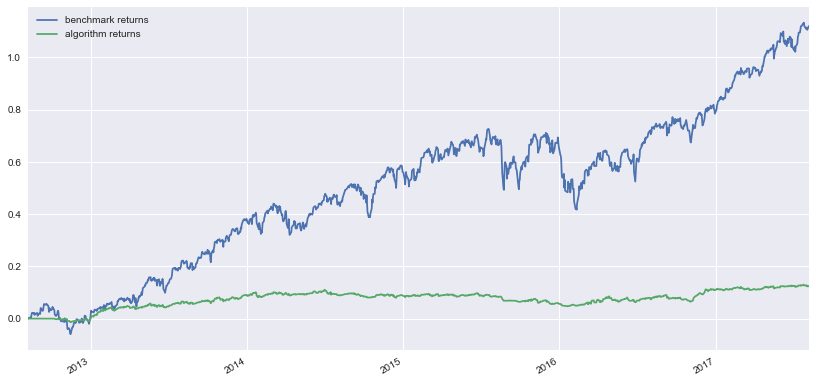

In [13]:
AbuMetricsBase.show_general(test_frm.orders_pd, 
                            test_frm.action_pd, test_frm.capital, test_frm.benchmark, only_show_returns=True)

转换出来的test_frm即是一个使用满仓乘数的度量对象，下面使用test_frm直接进行满仓度量即可：

买入后卖出的交易数量:29786
买入后尚未卖出的交易数量:625
胜率:46.5420%
平均获利期望:8.4243%
平均亏损期望:-5.7298%
盈亏比:1.3117
策略收益: 61.8465%
基准收益: 111.5646%
策略年化收益: 12.3890%
基准年化收益: 22.3484%
策略买入成交比例:100.0000%
策略资金利用率比例:29.7226%
策略共执行1258个交易日


<class 'abupy.MetricsBu.ABuMetricsBase.AbuMetricsBase'>


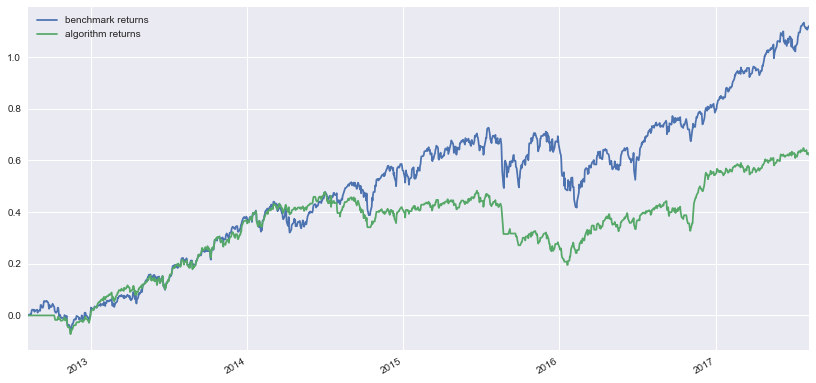

In [14]:
print(type(test_frm))
test_frm.plot_returns_cmp(only_show_returns=True)

小结：本节所有操作都非常耗时，特别是在cpu不够快的电脑上，建议睡觉的时候运行哈，下一节将使用本节回测好的数据进行ump训练优化示例。

#### abu量化文档目录章节

1. [择时策略的开发](http://www.abuquant.com/lecture/lecture_1.html)
2. [择时策略的优化](http://www.abuquant.com/lecture/lecture_2.html)
3. [滑点策略与交易手续费](http://www.abuquant.com/lecture/lecture_3.html)
4. [多支股票择时回测与仓位管理](http://www.abuquant.com/lecture/lecture_4.html)
5. [选股策略的开发](http://www.abuquant.com/lecture/lecture_5.html)
6. [回测结果的度量](http://www.abuquant.com/lecture/lecture_6.html)
7. [寻找策略最优参数和评分](http://www.abuquant.com/lecture/lecture_7.html)
8. [A股市场的回测](http://www.abuquant.com/lecture/lecture_8.html)
9. [港股市场的回测](http://www.abuquant.com/lecture/lecture_9.html)
10. [比特币，莱特币的回测](http://www.abuquant.com/lecture/lecture_10.html)
11. [期货市场的回测](http://www.abuquant.com/lecture/lecture_11.html)
12. [机器学习与比特币示例](http://www.abuquant.com/lecture/lecture_12.html)
13. [量化技术分析应用](http://www.abuquant.com/lecture/lecture_13.html)
14. [量化相关性分析应用](http://www.abuquant.com/lecture/lecture_14.html)
15. [量化交易和搜索引擎](http://www.abuquant.com/lecture/lecture_15.html)
16. [UMP主裁交易决策](http://www.abuquant.com/lecture/lecture_16.html)
17. [UMP边裁交易决策](http://www.abuquant.com/lecture/lecture_17.html)
18. [自定义裁判决策交易](http://www.abuquant.com/lecture/lecture_18.html)
19. [数据源](http://www.abuquant.com/lecture/lecture_19.html)
20. [A股全市场回测](http://www.abuquant.com/lecture/lecture_20.html)
21. [A股UMP决策](http://www.abuquant.com/lecture/lecture_21.html)
22. [美股全市场回测](http://www.abuquant.com/lecture/lecture_22.html)
23. [美股UMP决策](http://www.abuquant.com/lecture/lecture_23.html)

abu量化系统文档教程持续更新中，请关注公众号中的更新提醒。

#### 《量化交易之路》目录章节及随书代码地址

1. [第二章 量化语言——Python](https://github.com/bbfamily/abu/tree/master/ipython/第二章-量化语言——Python.ipynb)
2. [第三章 量化工具——NumPy](https://github.com/bbfamily/abu/tree/master/ipython/第三章-量化工具——NumPy.ipynb)
3. [第四章 量化工具——pandas](https://github.com/bbfamily/abu/tree/master/ipython/第四章-量化工具——pandas.ipynb)
4. [第五章 量化工具——可视化](https://github.com/bbfamily/abu/tree/master/ipython/第五章-量化工具——可视化.ipynb)
5. [第六章 量化工具——数学：你一生的追求到底能带来多少幸福](https://github.com/bbfamily/abu/tree/master/ipython/第六章-量化工具——数学.ipynb)
6. [第七章 量化系统——入门：三只小猪股票投资的故事](https://github.com/bbfamily/abu/tree/master/ipython/第七章-量化系统——入门.ipynb)
7. [第八章 量化系统——开发](https://github.com/bbfamily/abu/tree/master/ipython/第八章-量化系统——开发.ipynb)
8. [第九章 量化系统——度量与优化](https://github.com/bbfamily/abu/tree/master/ipython/第九章-量化系统——度量与优化.ipynb)
9. [第十章 量化系统——机器学习•猪老三](https://github.com/bbfamily/abu/tree/master/ipython/第十章-量化系统——机器学习•猪老三.ipynb)
10. [第十一章 量化系统——机器学习•ABU](https://github.com/bbfamily/abu/tree/master/ipython/第十一章-量化系统——机器学习•ABU.ipynb)
11. [附录A 量化环境部署](https://github.com/bbfamily/abu/tree/master/ipython/附录A-量化环境部署.ipynb)
12. [附录B 量化相关性分析](https://github.com/bbfamily/abu/tree/master/ipython/附录B-量化相关性分析.ipynb)
13. [附录C 量化统计分析及指标应用](https://github.com/bbfamily/abu/tree/master/ipython/附录C-量化统计分析及指标应用.ipynb)

[更多阿布量化量化技术文章](http://www.abuquant.com/article)

更多关于量化交易相关请阅读[《量化交易之路》](http://www.abuquant.com/books/quantify-trading-road.html)

更多关于量化交易与机器学习相关请阅读[《机器学习之路》](http://www.abuquant.com/books/machine-learning-road.html)

更多关于abu量化系统请关注微信公众号: abu_quant

![](./image/qrcode.jpg)